In [1]:
import scvelo as scv
from IPython.display import clear_output
import matplotlib.backends.backend_pdf
from tqdm import tnrange, tqdm_notebook
import scanpy as sc
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline


scv.logging.print_version()
scv.settings.set_figure_params(
    'scvelo', dpi_save=100, dpi=80, transparent=True)
scv.settings.verbosity = 2

Running scvelo 0.1.16.dev32+c00a55e.dirty (python 3.6.6) on 2021-01-27 10:50.


In [2]:
# paths and names
data_path='G:/data/scSLAMseq/revision/'
signatures_path='G:/data/scrnaseq_signature_collection/'
figure_path='G:/data/figures/heatmaps/'
libraries = ['AB', 'CE', 'DF']
donors=['B2-040', 'C2-019', 'OT227', 'OT302', 'P009T', 'P013T']

# DMSO latent time heatmap

In [76]:
obs=['Stem', 'Goblet', 'MAPK_progeny', 'YAP_targets', 'Stem_Lgr5_ISC-Merlos', 'TC1', 'TC4']
from scipy.stats import zscore
from matplotlib.backends.backend_pdf import PdfPages
export_path=data_path+'exports/25_01_DMSO/'

In [78]:
with PdfPages(export_path+'DMSO_sigs_vs_latenttime_heatmaps.pdf') as pdf:
    for obs_ in obs:
        from scipy.interpolate import interp1d
        Y = []
        for donor in donors:
            tab=pd.read_excel(data_path+'/DMSO_tables/DMSO_only_'+donor+'_ccreg_tables.xlsx')
            f = interp1d(tab['latent_time'], tab[obs_])
            y=f(np.linspace(0,1,1000))
            Y.append(y)
        Y = np.array(Y).T

        Y=zscore(Y)
        df = pd.DataFrame(Y, columns=donors)
        if True:
            n_convolve=50
            weights = np.ones(n_convolve) / n_convolve
            for o in donors:
                try:
                    df[o] = np.convolve(df[o].values, weights, mode="same")
                except:
                    print('convolve failed')
                    pass  # e.g. all-zero counts or nans cannot be convolved
        from seaborn import clustermap
        cm = clustermap(df.T, row_cluster=True, col_cluster=False, vmin=-2, vmax=2, cmap='bwr')#, **kwargs
        cm.ax_heatmap.set_xlabel('latent time');
        cm.ax_heatmap.set_title(obs_+' heatmap');
        cm.ax_heatmap.set_xticks([]);
        pdf.savefig()  # saves the current figure into a pdf page
        pl.close()

# Check old data

In [48]:
# Preload signatures

# Stem sig
tab=pd.read_excel(signatures_path+'cell_type_markers/CRC-related_stem_cell_signatures.xlsx', header=0)
tab = tab.drop(0)
sigs = {'Stem_'+x: list(tab[x][~pd.isna(tab[x])].values) for x in ['Lgr5_ISC-Munoz', 'Lgr5_ISC-Merlos']}

# Flo sig
# tab=pd.read_excel(signatures_path+'cell_type_markers/colonoid_cancer_uhlitz_markers.xlsx', header=1)
tab=pd.read_excel(signatures_path+'cell_type_markers/colonoid_cancer_uhlitz_markers_revised.xlsx', header=1, sheet_name=2)
flo_sigs={x: list(tab[tab['cell_type_epi']==x].gene.values) for x in ['Stem', 'Enterocytes 1', 'TC1', 'TC4', 'Goblet', 'Stem/TA 1']}

single_genes = ['LGR5', 'OLFM4', 'TFF3', 'FABP1', 'EPHB2', 'AXIN1', 'AXIN2', 'EGR1']

# YAP target from Markus Morkel, Liberali Lab
yap_targets = ['CTGF', 'GGTA1', 'WWC2', 'ANXA8', 'CLU', 'CXCL16', 'IL33', 'LY6A', 'LY6C1', 
               'MSLN', 'TNFRSF12A', 'CTGF', 'GGTA1', 'WWC2', 'ANXA5', 'TACSTD2', 'ANXA10', 'EREG', 'IL33', 'ANXA1', 'ANXA3']

# Hallmark apoptosis for rescoring
tab=pd.read_csv(signatures_path+'msigdb/hallmark/h.all.v6.2.symbols.gmt', sep='\t', header=None, index_col=0).T['HALLMARK_APOPTOSIS']
hallmark_apo = tab[~pd.isna(tab)].values[1:]

In [49]:
def annotate(adata, regress_cc=False):
    # Annotations
    # single genes of interest from Markus Morkel
    single_genes = ['LGR5', 'OLFM4', 'TFF3', 'FABP1', 'EPHB2', 'AXIN1', 'AXIN2', 'EGR1']

    k = sc.settings.verbosity
    sc.settings.verbosity = 0

    # cc score
    cell_cycle_genes = [x.strip() for x in open(signatures_path+'cell_cycle_genes/regev_lab_cell_cycle_genes.txt')]
    s_genes = cell_cycle_genes[:43]
    g2m_genes = cell_cycle_genes[43:]
    cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
    adata.obs_names_make_unique()
    sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
    # is it a problem that I score signatures before regressing out?
    if regress_cc:
        sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
    # adata = adata[adata.obs.phase=='G1'].copy()

    # Stem sig
    tab=pd.read_excel(signatures_path+'cell_type_markers/CRC-related_stem_cell_signatures.xlsx', header=0)
    tab = tab.drop(0)
    sigs = {'Stem_'+x: list(tab[x][~pd.isna(tab[x])].values) for x in tab.columns}
    for ct in ['Stem_Lgr5_ISC-Munoz', 'Stem_Lgr5_ISC-Merlos']:  #sigs.keys():
        sc.tl.score_genes(adata, sigs[ct], score_name=ct)

    # Flo sig
    # tab=pd.read_excel(signatures_path+'cell_type_markers/colonoid_cancer_uhlitz_markers.xlsx', header=1)
    tab=pd.read_excel(signatures_path+'cell_type_markers/colonoid_cancer_uhlitz_markers_revised.xlsx', header=1, sheet_name=2)
    flo_sigs={x: list(tab[tab['cell_type_epi']==x].gene.values) for x in pd.unique(tab['cell_type_epi'])}
    for ct in ['Stem', 'Enterocytes 1', 'Enterocytes 2', 'TC1', 'TC2', 'TC3', 'TC4', 'Goblet', 'Stem/TA 1', 'Stem/TA 2', 'Stem/TA 3']:  #flo_sigs.keys():
        sc.tl.score_genes(adata, flo_sigs[ct], score_name=ct)
    
    # Hallmarks
    tab=pd.read_csv(signatures_path + 'msigdb/hallmark/h.all.v6.2.symbols.gmt', sep='\t', index_col=0, header=None).drop(1, axis=1).T
    hallsigs={hallmark : tab[hallmark][~pd.isna(tab[hallmark])].values for hallmark in tab.columns}
    for hm in ['HALLMARK_DNA_REPAIR', 'HALLMARK_WNT_BETA_CATENIN_SIGNALING']:  #hallsigs.keys():
        sc.tl.score_genes(adata, hallsigs[hm], score_name=hm)
        

    # YAP target from Markus Morkel, Liberali Lab
    yap_targets = ['CTGF', 'GGTA1', 'WWC2', 'ANXA8', 'CLU', 'CXCL16', 'IL33', 'LY6A', 'LY6C1', 'MSLN', 'TNFRSF12A', 'CTGF', 'GGTA1', 'WWC2', 'ANXA5', 'TACSTD2', 'ANXA10', 'EREG', 'IL33', 'ANXA1', 'ANXA3']
    sc.tl.score_genes(adata, yap_targets, score_name='YAP_targets')

    sc.settings.verbosity = k
    return adata

In [55]:
# Define dynamic analysis pipeline
def old_dynamic_analysis(sigs, flo_sigs, hallmark_apo, single_genes, yap_targets, export_path):
    from scvelo.plotting.utils import default_size
    from matplotlib.backends.backend_pdf import PdfPages

    high_shared_vars = None
    top_dmso_genes = None
    
    donors=['NCO', 'P009ot', 'P013ot']
    perts=['E', 'W']

    for donor in donors:
        for pert in perts:
            # name format
            name = donor+'_'+pert
            print(name)

            # read
            adata=sc.read('G:/data/scSLAMseq/first_batch_AS/NB_AS_'+pert+'_'+donor+'SLAMvelo.h5')
            if 'X_diffmap' in adata.obsm.keys(): del adata.obsm['X_diffmap']
                
            adata = annotate(adata)

            # rescore hallmark apoptosis
            sc.tl.score_genes(adata, gene_list=hallmark_apo, score_name='HALLMARK_APOPTOSIS')

            scv.tl.recover_latent_time(adata, vkey='dyn_velo')

            writer = pd.ExcelWriter(export_path+name+'_tables.xlsx', engine='xlsxwriter')
            with PdfPages(export_path+name+'_dynamics.pdf') as pdf:
                # latent time series of signatures
                from scipy.stats import zscore
                obs = ['Stem', 'Goblet', 'YAP_targets', 'Stem_Lgr5_ISC-Merlos', 'TC1', 'TC4']
                colors = ['red', 'blue', 'green', 'black', 'grey', 'orange', 'yellow', 'cyan']
                ax=None
                for o, c in zip(obs,colors):
                    ax=scv.pl.scatter(adata, x=adata.obs.latent_time, y=zscore(adata.obs[o]), alpha=0.5, figsize=[10,5], size=50,
                                      color=c, n_convolve=50, show=False, xlabel='latent time', ylabel='zscore', ax=ax)
                ax.legend(obs)
                pdf.savefig()  # saves the current figure into a pdf page
                pl.close()

                # heatmap time series
                time = adata.obs.latent_time
                Y=adata.obs[obs].iloc[np.argsort(time)]
                #Y/=np.max(np.abs(Y), axis=0)
                Y=zscore(Y)
                df = pd.DataFrame(Y, columns=obs)
                if True:
                    n_convolve=50
                    weights = np.ones(n_convolve) / n_convolve
                    for o in obs:
                        try:
                            df[o] = np.convolve(df[o].values, weights, mode="same")
                        except:
                            pass  # e.g. all-zero counts or nans cannot be convolved
                from seaborn import clustermap
                cm = clustermap(df.T, row_cluster=True, col_cluster=False, vmin=-2, vmax=2, cmap='bwr')#, **kwargs
                cm.ax_heatmap.set_xlabel('latent time');
                cm.ax_heatmap.set_title(donor+' heatmap');
                cm.ax_heatmap.set_xticks([]);
                pdf.savefig()  # saves the current figure into a pdf page
                pl.close()

                # export Sigs vs time
                dat=adata.obs[['latent_time']+obs].sort_values('latent_time')
                dat.to_excel(writer, sheet_name='signatures_vs_latenttime')

                ### UMAPs Signatures etc ###
                size = 4 * default_size(adata)
                alpha = 0.4
                ncols=4
                show=False
                umap_kwargs = {'size':size, 'alpha':alpha, 'ncols':ncols, 'show': show}

                # umaps signatures
                color = ['Stem', 'Goblet', 'YAP_targets', 'Stem_Lgr5_ISC-Merlos', 'TC1', 'TC2', 'TC3', 'TC4', 
                         'latent_time', 'HALLMARK_APOPTOSIS', 'HALLMARK_DNA_REPAIR', 'phase']
                scv.pl.scatter(adata, color=color, **umap_kwargs)
                pdf.savefig()  # saves the current figure into a pdf page
                pl.close()

                # UMAP genes
                single_genes = np.array(['LGR5', 'OLFM4', 'TFF3', 'FABP1', 'EPHB2', 'AXIN1', 'AXIN2', 'EGR1'])
                single_genes=single_genes[np.isin(single_genes, adata.var_names)]
                scv.pl.scatter(adata, color=single_genes, **umap_kwargs)
                pdf.savefig()  # saves the current figure into a pdf page
                pl.close()

                scv.pl.scatter(adata, color=single_genes, layer='Ms', **umap_kwargs)
                pdf.savefig()  # saves the current figure into a pdf page
                pl.close()

                scv.pl.scatter(adata, color=single_genes, layer='Mu', **umap_kwargs)
                pdf.savefig()  # saves the current figure into a pdf page
                pl.close()

                ### Dynamics / Velocity plots

                # dynamical velocity plot
                from scvelo.plotting.utils import default_size
                scv.pl.velocity_embedding_grid(adata, color='latent_time', vkey='dyn_velo', arrow_length=5, arrow_size=5, density=0.4, arrow_color='black', show=False, title=donor+' '+pert+' dynamical velocity')
                pdf.savefig()  # saves the current figure into a pdf page
                pl.close()
                
                scv.settings.figdir = export_path
                scv.pl.velocity_embedding_stream(adata, color='latent_time', vkey='dyn_velo', show=False, title=donor+' '+pert+' dynamical velocity', save=donor+'_'+pert+'_stream.png', colorbar=False, dpi=200)
                pl.close()

                ### PHASE PLOTS ###

                # overall top likelihood genes
                topgenes = list(adata.var.fit_likelihood[~pd.isna(adata.var.fit_likelihood)].sort_values()[-20:].index)
                scv.pl.scatter(adata, basis=topgenes, color='latent_time', ncols=4, show=False, title=[x+' top'+str(20-i) for i,x in enumerate(topgenes)])
                pdf.savefig()  # saves the current figure into a pdf page
                pl.close()

                # export gene fit likelihoods of highest quantile
                genes_likelihoods=adata.var[~pd.isna(adata.var['fit_likelihood'])]['fit_likelihood'].sort_values()
                top_genes_likelihoods=genes_likelihoods[genes_likelihoods>np.percentile(genes_likelihoods,75)]
                top_genes_likelihoods.to_excel(writer, sheet_name='top_quantile_genes_likelihoods')

                # calculate gene overlaps with sigs
                genes = top_genes_likelihoods #genes_likelihoods
                #print('Selected fitted genes', '\t', len(genes))
                dat = []
                index = []
                intersets = []
                signatures = {**sigs, **flo_sigs, **{'yap_targets':yap_targets}, **{'single_genes': single_genes}}
                for k in signatures.keys():
                    K = np.sum(np.isin(genes.index, signatures[k]))
                    dat.append([K, len(signatures[k])])
                    index.append(k)
                    intersets.append(genes.index.values[np.isin(genes.index, signatures[k])])
                tab=pd.DataFrame(data=dat, index=index, columns=['overlap', 'total_in_sig'])
                tab['percent_coverage']=np.round(tab.overlap/tab.total_in_sig*100,2)
                tab['intersecting_genes']=intersets
                tab.to_excel(writer, sheet_name='sigantures_overlap_statistics')

            writer.save()

In [56]:
export_path=data_path+'exports/25_01_olddata_newpipeline/'
old_dynamic_analysis(sigs, flo_sigs, hallmark_apo, single_genes, yap_targets, export_path)

NCO_E
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00)
computing latent time using root_cells as prior
    finished (0:00:06)
computing velocity embedding
    finished (0:00:00)
saving figure to file G:/data/scSLAMseq/revision/exports/25_01_olddata_newpipeline/scvelo_NCO_E_stream.png
NCO_W
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00)
computing latent time using root_cells as prior
    finished (0:00:18)
computing velocity embedding
    finished (0:00:01)
saving figure to file G:/data/scSLAMseq/revision/exports/25_01_olddata_newpipeline/scvelo_NCO_W_stream.png
P009ot_E
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00)
computing latent time using root_cells as prior
    finished (0:00:06)
computing velocity embedding
    finished (0:00:01)
saving figure to file G:/data/scSLAMseq/revisio

# AXIN2 vs latent time in P013T

In [65]:
tab = pd.read_excel(data_path+'exports/07_01_investigation_dynamics/DMSO_only_P013T_ccreg_tables.xlsx')

In [89]:
export_path=data_path+'exports/26_01_AXIN2/'
scv.settings.figdir = export_path

saving figure to file G:/data/scSLAMseq/revision/exports/26_01_AXIN2/scvelo_AXIN2_vs_latent_time_EGFR.png


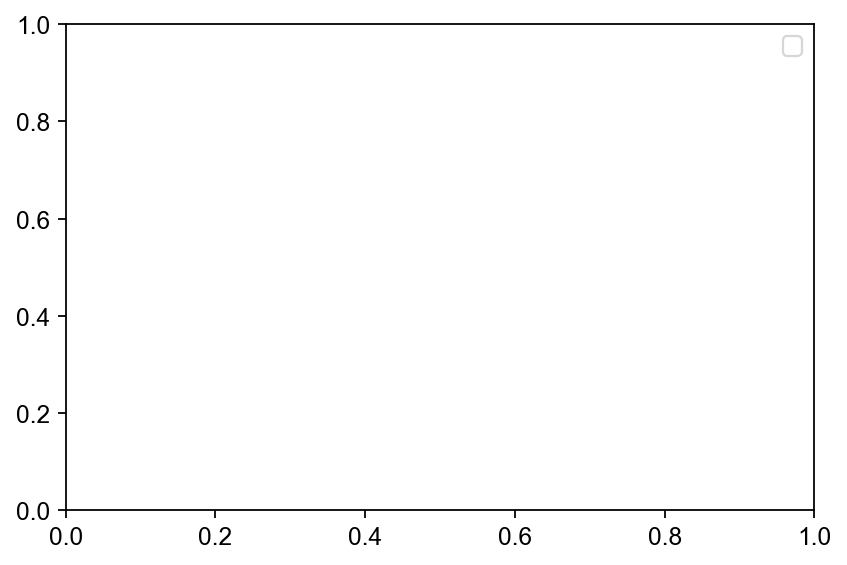

In [94]:
adata=scv.read(data_path+'EGFR_only_P013T_ccreg_savemodel.h5')
ax = scv.pl.scatter(adata, x=adata.obs.latent_time, y=adata[:,'AXIN2'].layers['Ms'],n_convolve=10, color='darkred', show=False, alpha=0.5)
ax=scv.pl.scatter(adata, x=adata.obs.latent_time, y=adata[:,'AXIN2'].layers['Mu'],n_convolve=10, color='rot', 
               show=False, ax=ax, ylabel='AXIN2 moments', xlabel='latent time', title='P013T EGFRi', alpha=0.5, save='AXIN2_vs_latent_time_EGFR.png')

adata=scv.read(data_path+'DMSO_only_P013T_ccreg_savemodel.h5')
ax = scv.pl.scatter(adata, x=adata.obs.latent_time, y=adata[:,'AXIN2'].layers['Ms'],n_convolve=10, color='red', show=False, alpha=0.5, ax=ax)
scv.pl.scatter(adata, x=adata.obs.latent_time, y=adata[:,'AXIN2'].layers['Mu'],n_convolve=10, color='blue', 
               show=False, ax=ax, ylabel='AXIN2 moments', xlabel='latent time', title='P013T DMSO', alpha=0.5, save='AXIN2_vs_latent_time_DMSO.png')

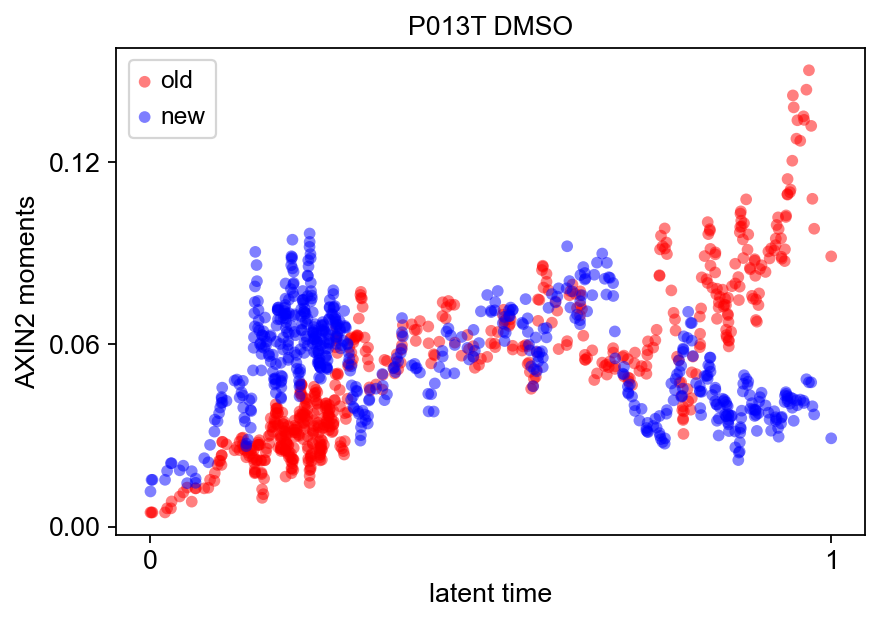

In [93]:
adata=scv.read(data_path+'DMSO_only_P013T_ccreg_savemodel.h5')
ax = scv.pl.scatter(adata, x=adata.obs.latent_time, y=adata[:,'AXIN2'].layers['Ms'],n_convolve=10, color='red', show=False, alpha=0.5)
scv.pl.scatter(adata, x=adata.obs.latent_time, y=adata[:,'AXIN2'].layers['Mu'],n_convolve=10, color='blue', 
               show=False, ax=ax, ylabel='AXIN2 moments', xlabel='latent time', title='P013T DMSO', alpha=0.5, save='AXIN2_vs_latent_time_DMSO.png')
pl.legend(['old', 'new'])